In [2]:
import arviz as az
import numpy as np
import preliz as pz
import pymc as pm

np.random.seed(321)
#---------#---------#---------#---------#---------#---------#---------#---------

### 2.1 Flipping Coins the PyMC Way

- θ ~ Beta(α=1, β=1)
- Υ ~ Binomial(n=1, p=θ)

In [14]:
trials = 4
theta_real = 0.35
data = pz.Binomial(n=1, p=theta_real).rvs(trials)

In [15]:
with pm.Model() as first_mod:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)
    idata = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


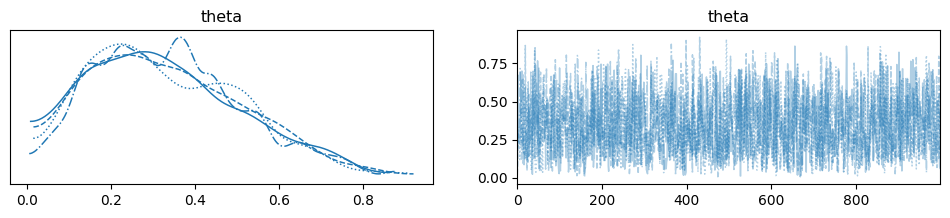

In [16]:
az.plot_trace(idata);

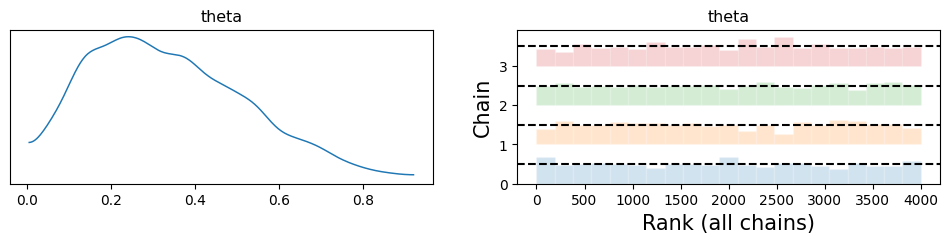

In [17]:
az.plot_trace(idata, kind='rank_bars', combined=True);

In [18]:
az.summary(idata, kind='stats').round(3)

,mean,sd,hdi_3%,hdi_97%
theta,0.335,0.181,0.024,0.659


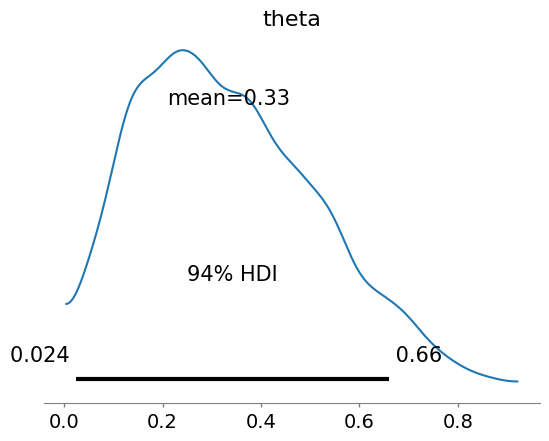

In [19]:
az.plot_posterior(idata);

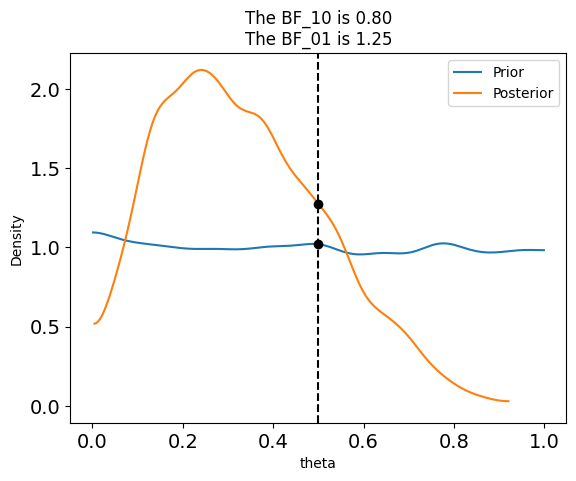

In [21]:
az.plot_bf(
    idata, var_name='theta', prior=np.random.uniform(0, 1, 10_000), ref_val=0.5);

Value of theta is 1.25 (BF_01)x more likely under posterior than prior.
BF_10: value of theta not being 0.5: 0.80x more likely under posterior than prior.

Rule of thumb: BF_01:
- 1 - 3.2: barely worth mentioning
- 3.2 - 10: substantial
- 10 - 100: strong
- 100+: decisive